Idea is explore the intrinsic component of the AMOC in the ensemble using the idea that it is created by two "switches"/"noisemakers".

These are two eddying regions at the base of South Africa and in the Gulf of Mexico. The idea is that these are important contributers to the intrinsic component. The actual AMOC may have different sources of wariability, but describing the source and potential magnitude of differences created by these "switches"/"noisemakers" would be valuable to estimate reasonable differences between simulations.





- Let's formulate a Structural Equation Model (SEM, also called a Causal Graph or Path Diagram), to see if we can encode our assumptions about how the intrinsic variability in AMOC is generated.  

- A SEM gives us a formal and transparent representation of out *causal assumptions* e.g. The intrinsic AMOC has two "switches"/"noisemakers".


Let $U$ be the error term, correlated. The latent variables of the two  "switches"/"noisemakers" are $Q$. These latent variables are used to represent the unknown things the intrinsic component of the meridional circulation does between the two  "switches"/"noisemakers".

$$Q_1 = U_1$$
$$S_{AG} = aQ_1 + U_2$$
$$S_{GR} = bS_{AG} + U_3$$
$$Q_2 = eQ_1 + dC +U_4$$

$$\Psi = c S_{GR} + fQ_2 + U_5$$

To get at this regression problem, we say:
$$S_{AR} = aQ_1 + U_{S_{AR}}$$
$$S_{GR} = b S_{AR}+U_{S_{GR}}$$
$$\Psi = \beta S_{GR} + U_{\Psi}$$



### More coming soon.... Like a figure...

# The AMOC data

We start by loading the AMOC data like Stephanie Leroux describes.

## Load the OCCIPUT data

In [1]:


## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr
    
# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import scipy.io

%matplotlib inline



In [2]:
### local (my laptop for now)
diri = "/home/maike/Documents/OCCIPUT/"
fili = "AMOCSIG.ORCA025.L75-OCCITENS.1960-2015.nc"

In [3]:
amoc = xr.open_dataset(diri+fili)['amoc']

We can plot the AMOC data.

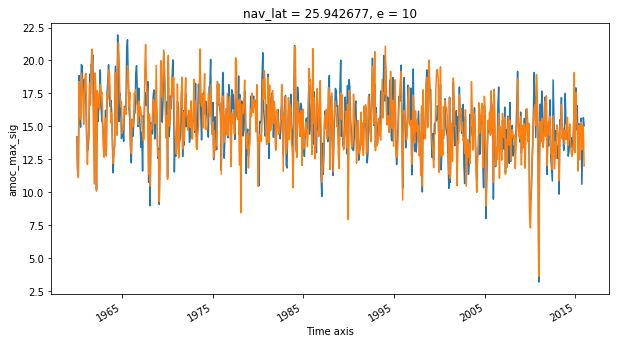

In [7]:

#This selects the AMOC at the latitude of an observational array called "RAPID" at 26 degrees North. 
#I'm not sure what the flag "e" means, and the documentation wasn't terribly helpful. I assume it is e for "ensemble".
# So we are looking at member 1 and 10.
rapidmb1 = amoc.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc.sel(nav_lat=26.,method='nearest',e=10)

# plot. Time is along the x-axis and the AMOC on the y axis in Sverdrup (Sv=10^6m3/s)
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

Below, Stephanie looks at the mean and standard deviation along the ensemble dimention (dim='e'). 

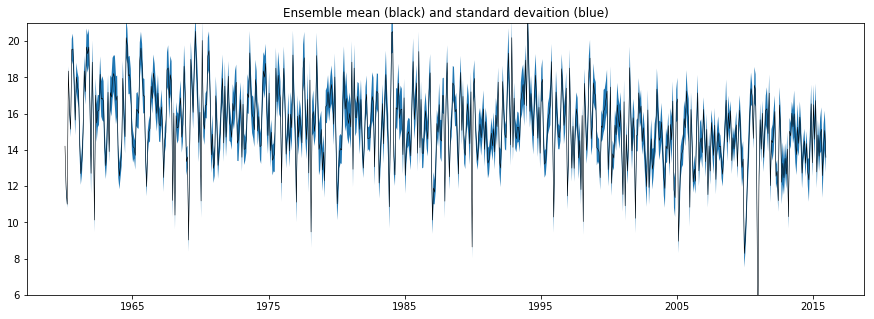

In [9]:
# choose latitude
latchoice = 26.

emean = amoc.mean(dim='e')
estd  = amoc.std(dim='e')

emeanplus = emean+estd
emeanminus = emean-estd


y  = emean.sel(nav_lat=latchoice,method='nearest')
yp = emeanplus.sel(nav_lat=latchoice,method='nearest')
ym = emeanminus.sel(nav_lat=latchoice,method='nearest')

x=emean.time_counter.values

# plot
fig2 = plt.figure(figsize=([15,5]),facecolor='white')  

# emean (black)
plt.plot(x,y,color='k',linewidth=0.5)
# emean +/- 1sd shaded (blue)
plt.fill_between(x,ym,yp)

plt.ylim( 6., 21. )  
plt.title('Ensemble mean (black) and standard devaition (blue)')
plt.show()

In [11]:
#We can print the values too
latchoice = -34.5
tmestd = estd.sel(nav_lat=latchoice,method='nearest').mean(dim='time_counter')
tmestd.values

array(1.72815234)

# Now detrend the amoc dataset with a loess method



Detrended as in Leroux et al 2018:

S. Leroux, T. Penduff, L. Bessieres, J.-M. Molines, J.-M. Brankart, G. Serazin, B. Barnier, and L. Ter- ray. Intrinsic and atmospherically forced variability of the amoc: Insights from a large-ensemble ocean hindcast. Journal of Climate, 31(3):1183–1203, 2018.


In [12]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
# Since rpy2 version 2.3, it is necessary to activate the automatic 
# conversion from numpy to R arrays
if hasattr(rpy2.robjects.numpy2ri, 'activate'):
   rpy2.robjects.numpy2ri.activate()

################################################
################################################
def loess_detrend(ts, time, span=0.99, degree=2):
    """ non-linear loess detrending inspired from Guillaume Serrazin's tools
        Uses R package for Python
        This loess filter is set for parameters (span 0.99, degree=2) that
        are equivalent to a HP filter of cutoff period = half the total time-segment.
        
        Note: wgts is a vector containing the weights to apply on the operator for each time-step. T
        he normal usage is to set wgts to 0.   Ex:  wgts = np.ones(len(data) ). But sometimes you might
        need to impose that the first time step of the timeseries (data[0]) should be invariant through 
        the loess operator. In that case, just set the first weight to a high number. Ex: wgts[0]=1000.  
    """
    rloess = robjects.r['loess']
    fmla = robjects.Formula('y ~ x')
    env = fmla.environment
    env['x'] = time
    env['y'] = ts
    ts_dtr = np.array(rloess(fmla, span=span, degree=degree)[2])
    return ts_dtr

### Apply detrending and save. NB: THIS TAKES A LITTLE TIME (only ca 15 min on a laptop).

In [21]:
il=1
ie=1
for ie in range(0,amoc.e.size):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_dt = loess_detrend(ts, \
                       np.arange(0,amoc.time_counter.size,1), \
                       span=0.99, degree=2)
        
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

In [14]:
#We save a netCDF file
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':inxr.time_counter,'e': inxr.e, 'nav_lat': inxr.nav_lat})

outfi = diri+'AMOCSIG.ORCA025.L75-OCCITENS.1960-2015_dt.nc'
amoc_dt1_def.name='amoc_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc (loess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')

NameError: name 'concconcamoc' is not defined

In [13]:
amoc_dtREAD = xr.open_dataset(diri+'AMOCSIG.ORCA025.L75-OCCITENS.1960-2015_dt.nc')['amoc_dt']

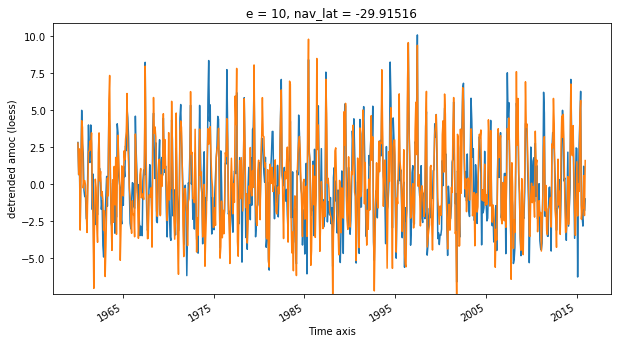

In [15]:
rapidmb1 = amoc_dtREAD.sel(nav_lat=-30.,method='nearest',e=1)
rapidmb2 = amoc_dtREAD.sel(nav_lat=-30.,method='nearest',e=10)

# plot 
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

Lovely detrended data! This is much better to work with, but the seasonal cycle still remains....

## The SSH data 

We work initially only on ensemble member 42. This SSH data is *detrended*, and split into the climatological ($SSH_{clim}$) and anomaly ($SSH_{anom}$), meaning: $$SSH = SSH_{anom}+SSH_{clim}$$

In [24]:
#We load the climatology that consists of a 12dimentional (months) vector
ssh_clim = xr.open_dataset(diri+'ORCA025.L75-OCCITENS.042_monclim.nc')['ssh']

#ssh =np.array([0]*10)
#The data is saved with one datafile per year (yy). We load this, add the climatology, and concatenate.
for yy in np.arange(1979, 2016):
    if yy==1979: #The first year we make the arrays first
        ssh_anom = xr.open_dataset(diri+'ORCA025.L75-OCCITENS.042_y{:1d}.mons_ssha.nc'.format(yy))['ssh']
        ssh = ssh_anom+np.array(ssh_clim)
        ssh_anom1979to2016 = ssh_anom
    else:
        ssh_anom = xr.open_dataset(diri+'ORCA025.L75-OCCITENS.042_y{:1d}.mons_ssha.nc'.format(yy))['ssh']
        #For some reason it doesn't like it if you just add two... but if one is an array it's OK.
        ssh_snapshot =ssh_anom+np.array(ssh_clim)
        ssh = xr.concat([ssh[:], ssh_snapshot[:]], dim='time_counter')
        ssh_anom1979to2016=xr.concat([ssh_anom1979to2016[:], ssh_anom[:]], dim='time_counter')

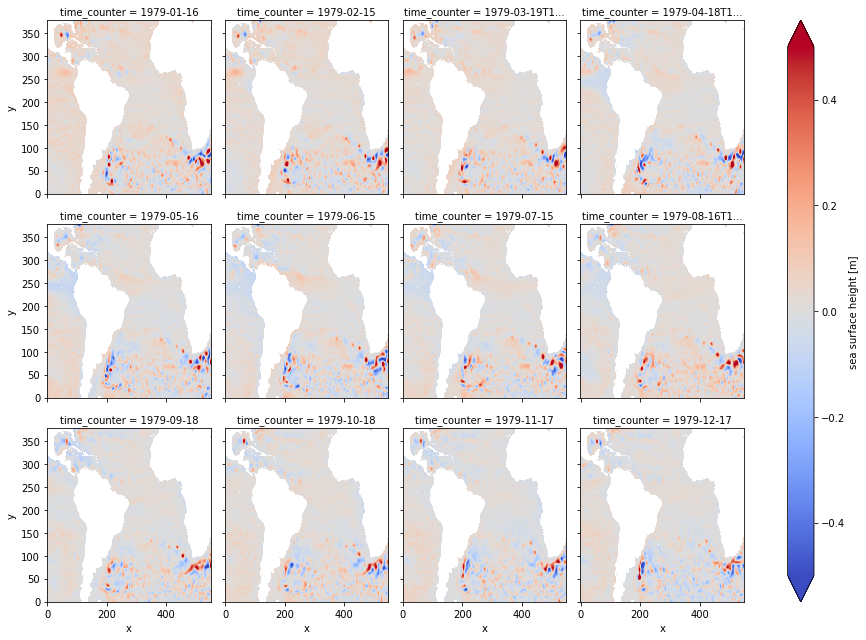

In [50]:
ssh.plot.imshow('x', 'y', col='time_counter', col_wrap=4, cmap='coolwarm', vmin=-0.5, vmax=0.5)

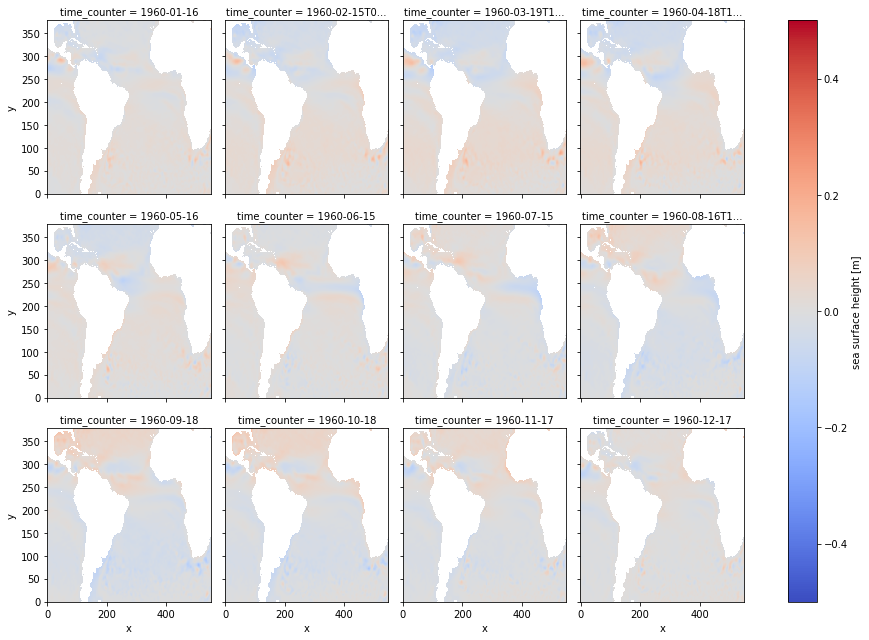

In [61]:
ssh_clim.plot.imshow('x', 'y', col='time_counter', col_wrap=4, cmap='coolwarm', vmin=-0.5, vmax=0.5)

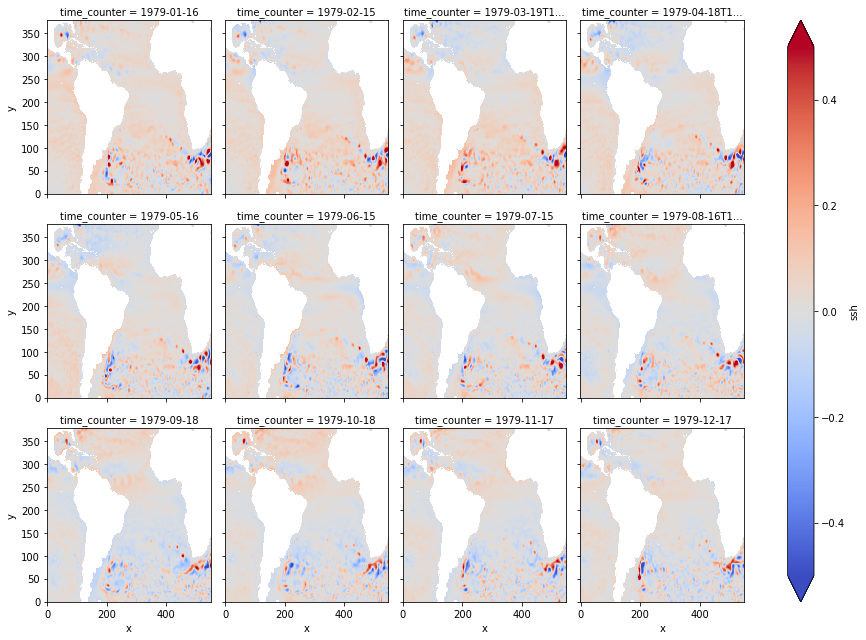

In [113]:
ssh.plot.imshow('x', 'y', col='time_counter', col_wrap=4, cmap='coolwarm', vmin=-0.5, vmax=0.5)

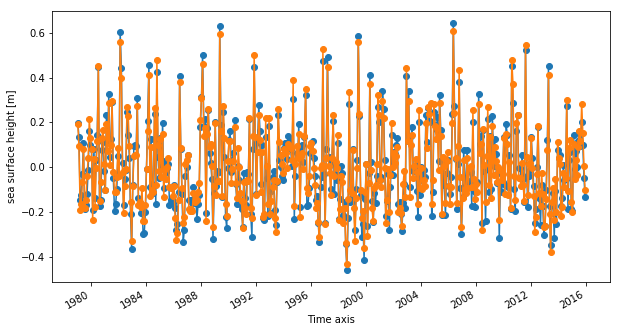

In [25]:
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
ssh[:, 75,470].plot(marker='o')
ssh_anom1979to2016[:, 75,470].plot(marker='o')


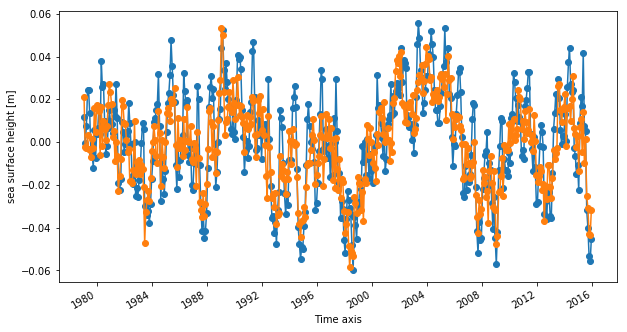

In [26]:
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
ssh[:, 200,370].plot(marker='o')
ssh_anom1979to2016[:, 200,370].plot(marker='o')


In [1]:


from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()



ImportError: No module named causalgraphicalmodels